In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [168]:
data = pd.read_csv('netflix_titles.csv')

In [169]:
print(data.shape)
data.head()

(8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


The 'show_id' Values are the same as the index column, but with an s! To have only integers, to easily access each content, we can delete the 'show_id' column and name the index 'id':

In [170]:
data.drop(columns=['show_id'], inplace=True)
data.rename_axis('id', inplace=True)
data.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
id,,,,,,,,,,,
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


We can already see that some values are missing or were wrongly introduced (Nan), so let's check exactly how our data frame looks:

In [171]:
data['date_added'] = pd.to_datetime(data['date_added'] , errors='coerce')
describe_data = pd.DataFrame(data.dtypes)
describe_data=describe_data.rename(columns={describe_data.columns[0]:'Data type'})
describe_data['Null Values'] = data.isnull().sum()
describe_data['%'] = (data.isnull().sum() / data.shape[0]) * 100
describe_data

,Data type,Null Values,%
type,object,0,0.000000
title,object,0,0.000000
director,object,2634,29.908028
cast,object,825,9.367549
country,object,831,9.435676
date_added,datetime64[ns],98,1.112751
release_year,int64,0,0.000000
rating,object,4,0.045418
duration,object,3,0.034064
listed_in,object,0,0.000000


In [172]:
data = data.dropna(axis=0)
print(data.shape)

(5328, 11)


Although some data was lost, we still have quite a lot of values to be working with so we'll be using those.
Let's start by vectorzing the movie/show descriptions so that we can use a model that will be able to identify similiar ones.

Let's now analize this dataframe to have a feel of what the data tells us!


In [173]:
data['type'] = data['type'].astype('category')
data['rating'] = data['rating'].astype('category')
#turning to categories because they are categorical variables

data['genres'] = data['listed_in'].apply(lambda x: [genre.strip() for genre in x.split(',')])
#creates a list of genres for each entry

(array([0, 1]), [Text(0, 0, 'Movie'), Text(1, 0, 'TV Show')])

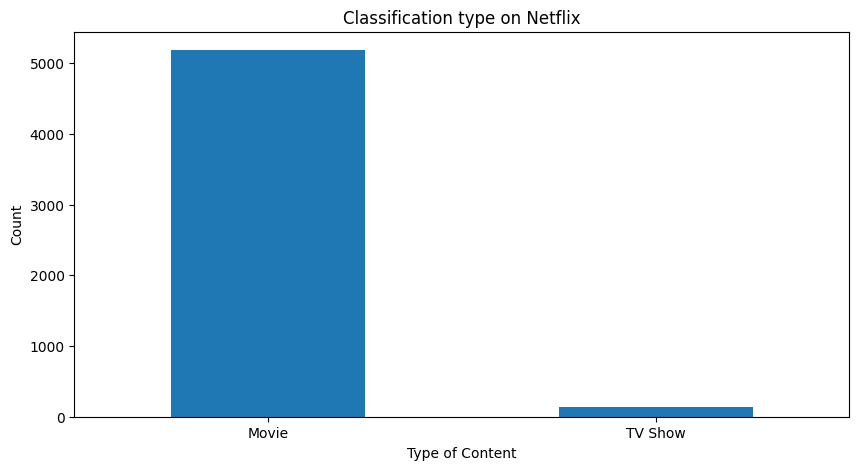

In [174]:
ax, fig = plt.subplots(figsize=(10, 5))
ax = data['type'].value_counts().plot(kind='bar', title='Classification type on Netflix')
plt.xlabel('Type of Content')
plt.ylabel('Count')
plt.xticks(rotation=0)

<Axes: title={'center': 'Movies'}, ylabel='count'>

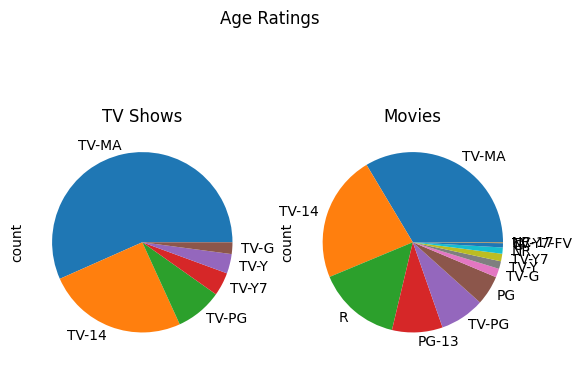

In [175]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Age Ratings')
axs[0].set_title('TV Shows')
axs[1].set_title('Movies')
data.loc[data['type']== 'TV Show']['rating'].value_counts().plot(kind='pie', ax=axs[0])
data.loc[data['type']== 'Movie']['rating'].value_counts().plot(kind='pie', ax=axs[1])


We can see that we have 2 different types of age ratings, one governed by TV Parental Guidelines
and other by the MPAA, but they are equivalent in the sense that both restrict an age appropriate for the content in question.

In order to have a model capable of recommending movies where age recommendation is a criteria, we can convert TV Parental Guidelines to MPAA (since this last one is more recognized)

In [176]:
data['rating'].value_counts()

rating
TV-MA       1822
TV-14       1213
R            778
PG-13        470
TV-PG        428
PG           275
TV-G          84
TV-Y          76
TV-Y7         76
NR            58
G             40
TV-Y7-FV       3
UR             3
NC-17          2
Name: count, dtype: int64

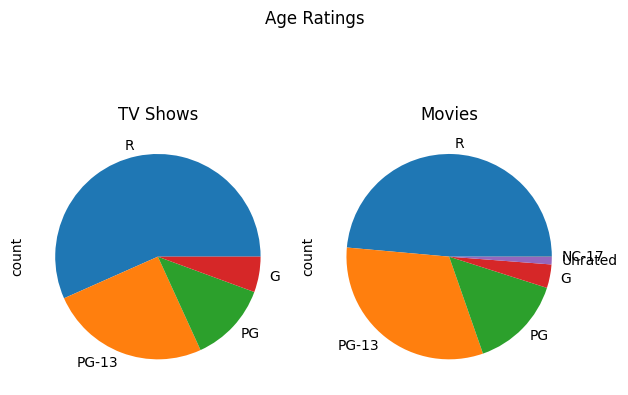

In [177]:
rating_conversion = {
    'TV-MA': 'R',
    'TV-14': 'PG-13',
    'TV-PG': 'PG',
    'TV-G': 'G',
    'TV-Y7': 'PG',      
    'TV-Y7-FV': 'PG',   
    'TV-Y': 'G',        
    
    'R': 'R',
    'PG-13': 'PG-13',
    'PG': 'PG',
    'G': 'G',
    'NC-17': 'NC-17',
    
    'NR': 'Unrated',
    'UR': 'Unrated'
}

data['converted_rating'] = data['rating'].map(rating_conversion)

fig, axs = plt.subplots(1, 2)
fig.suptitle('Age Ratings')
axs[0].set_title('TV Shows')
axs[1].set_title('Movies')
data.loc[data['type']== 'TV Show']['converted_rating'].value_counts().plot(kind='pie', ax=axs[0])
data.loc[data['type']== 'Movie']['converted_rating'].value_counts().plot(kind='pie', ax=axs[1])

plt.tight_layout()
plt.show()

Now the comparison will be much smoother and we can see that most of the content is R-rated!

We will now analyse the country the productions were made in and the date they were added:

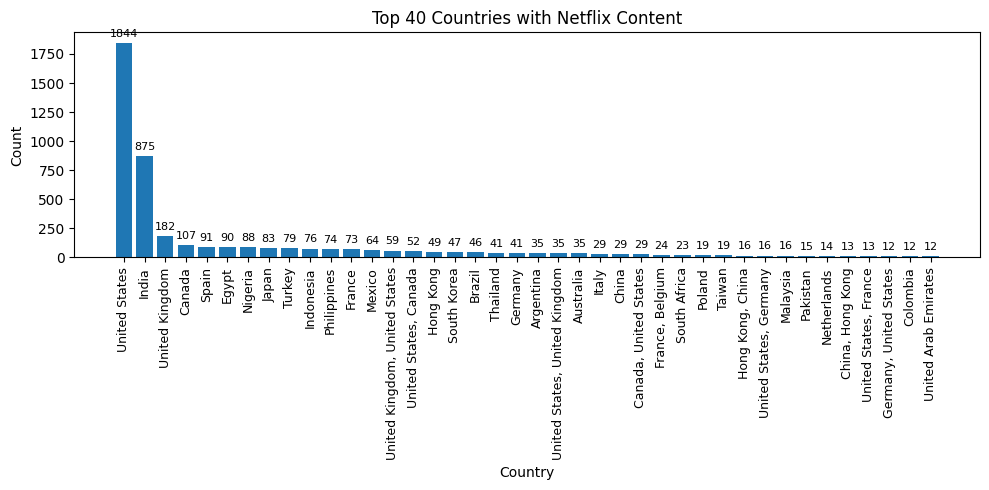

In [178]:
fig, ax = plt.subplots(figsize=(10, 5))

country= data['country'].value_counts().head(40)
bars = ax.bar(country.index, country.values)
ax.bar_label(bars, padding=3, fontsize=8)
ax.set_xlabel('Country')
ax.set_ylabel('Count')
ax.set_title('Top 40 Countries with Netflix Content')
ax.tick_params(axis='x', rotation=90, labelsize=9) 

plt.tight_layout()
plt.show()


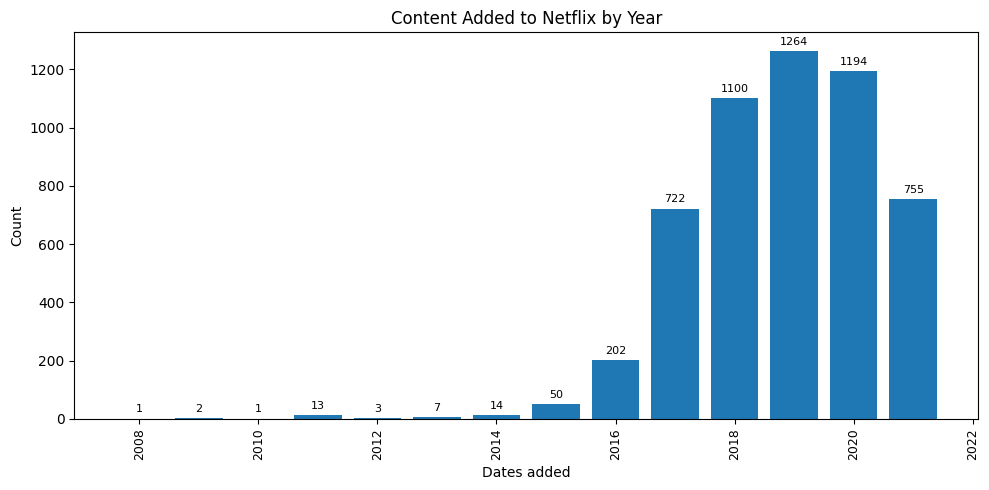

In [179]:
fig, ax = plt.subplots(figsize=(10, 5))


dates = data['date_added'].dt.year.value_counts().sort_index()
bars = ax.bar(dates.index, dates.values)
ax.bar_label(bars, padding=3, fontsize=8)
ax.set_xlabel('Dates added')
ax.set_ylabel('Count')
ax.set_title('Content Added to Netflix by Year')
ax.tick_params(axis='x', rotation=90, labelsize=9) 

plt.tight_layout()
plt.show()


Now onto the machine learnng models, let's try to create one that, receiving a movie/show, can recommend similar ones. 

All of the columns give us information about each of the show/movie they're related to, but some seem to be more important than others. 
The description, per example, which tells what the movie is about, along with the genre (in listed_in) are probably the strongests features, altough others like cast, director and rating carry importance aswell.

Let's start with these 5 features as a basis for a model.  
We can use TF-IDF vectorizing to identify the most common/important words for each of the selected features! This technique will be very useful because it converts string values into numerical ones, making them comparable:

In [180]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [181]:
tfidf_genres = TfidfVectorizer(stop_words='english')
tfidf_desc = TfidfVectorizer(stop_words='english')
tfidf_cast = TfidfVectorizer(stop_words='english')
tfidf_director = TfidfVectorizer(stop_words='english')

#genre
tfidf_genres_matrix = tfidf_genres.fit_transform(train_data['listed_in'])

#description
tfidf_desc_matrix = tfidf_desc.fit_transform(train_data['description'])

#cast
tfidf_cast_matrix = tfidf_cast.fit_transform(train_data['cast'])

#director
tfidf_director_matrix = tfidf_director.fit_transform(train_data['director'])

Now, in each tfidf_feature variable, we have a matrix where the rows are the movies, having a vector for each one that represents words present in each feature.
There will be similarities between the vectors of movies with similarities between them.

So, let's use the cosine_similarity function from sklearn, to obtain a matrix that will compute the similarities between vectors form different movies:

In [182]:
sim_genres = cosine_similarity(tfidf_genres_matrix)
sim_desc = cosine_similarity(tfidf_desc_matrix)
sim_cast = cosine_similarity(tfidf_cast_matrix)
sim_director = cosine_similarity(tfidf_director_matrix)

In each of the variables, we have a matrix, whose entries return the similarity between the movie whose index corresponds to the row and the one whose index corresponds to the column. 

Now, although we imagine all these features are important, we also assumed that description, per example, may be more important to determine another recommendation in comparison with director. 
Let's add this 'importance' in the form of weight in our model, creating a final similarity matrix:

In [183]:
final_ = (0.4*sim_genres + 0.4*sim_desc + 0.1*sim_cast + 0.1*sim_director) 
#weights are a estimation and may be adjusted according to the performance of the model

Now, if we were to create a function that calculates a recommendation based on a movie/show from the training dataset, it would be extremely easy since we can just find their index, go to the respective row and find the other movies/shows with the most similar vectors in the final_ matrix. But, to make a model that can accept any input, we need to have that content's features, so we can create a matrix and compare it to the one created with our training data. 

In [184]:
def recommendation(movie_features, n=10): #n is the number of recommendations
                                           #movie_features is a vector with the features of the movie
    
    #using the same vectors as the original database!
    movie_genres = tfidf_genres.transform(movie_features['listed_in'])
    movie_desc = tfidf_desc.transform(movie_features['description'])
    movie_cast = tfidf_cast.transform(movie_features['cast'])
    movie_director = tfidf_director.transform(movie_features['director'])

    #weights for each feature
    weights = {'listed_in': 0.4, 'description': 0.4, 'cast': 0.1, 'director': 0.1}
    for name, vec in [('listed_in', movie_genres), ('description', movie_desc),
                      ('cast', movie_cast ), ('director',  movie_director)]:
        if vec.nnz == 0: #cheching if the vector is empty
            weights[name] = 0
            print(f"Warning: {name} vector is empty, setting weight to 0")

    #adjusting weights
    total_weight = sum(weights.values())
    if total_weight ==0:
        print("Warning: All weights are 0, returning random recommendations")
        return train_data.sample(n, random_state=42)[['title']] #getting some recommendations randomly
    
    if total_weight != 1:
        weights = {k: v / total_weight for k, v in weights.items()} #setting the weights to sum to 1

    
    movie_sim_genres = cosine_similarity(movie_genres, tfidf_genres_matrix)
    movie_sim_desc = cosine_similarity(movie_desc, tfidf_desc_matrix)
    movie_sim_cast = cosine_similarity(movie_cast, tfidf_cast_matrix)
    movie_sim_director = cosine_similarity(movie_director, tfidf_director_matrix)

    final_sim = (weights['listed_in'] * movie_sim_genres + weights['description'] * movie_sim_desc + weights['cast'] * movie_sim_cast
                  + weights['director'] * movie_sim_director )
    
    top_indices = final_sim[0].argsort()[::-1][:n]
    return train_data.iloc[top_indices]




In [185]:
tester = test_data.iloc[0:1]
recommendations = recommendation(tester)

print("Based on your movie:\n")
print(f"{tester.iloc[0]['title']}\n")

print("... you might also like:\n")
for i in range(len(recommendations)):
    print(f" {recommendations.iloc[i]['title']}")


Based on your movie:

Spy Time

... you might also like:

 Superlopez
 Beauty and the Bestie
 Heroes Wanted
 Get the Goat
 All Because of You
 Namak Halaal
 Rowdy Rathore
 Bitcoin Heist
 Bodyguard
 MFKZ


In [186]:
movie = test_data.iloc[30:31]
recs = recommendation(movie)

print("Based on your movie:\n")
print("title:" ,movie['title'].values[0])
print("Genres:", movie['listed_in'].values[0])
print("Description:", movie['description'].values[0])
print("Cast:", movie['cast'].values[0])
print("Director:", movie['director'].values[0])

print("\n You may also like:\n")
for i, (_, row) in enumerate(recs.iterrows(), 1):
    print(f"{i}.  {row['title']}")
    print(f"    Genres: {row['listed_in']}")
    print(f"    Director: {row['director']}")
    print(f" Description: {row['description']}\n")


Based on your movie:

title: Crime Diaries: Night Out
Genres: Crime TV Shows, International TV Shows, Spanish-Language TV Shows
Description: After going to a Halloween party, college student Luis Andrés Colmenares is found dead. Was it an accident or murder? Inspired by true events.
Cast: Sebastián Osorio, Fabiana Medina, Laura Osma, Enrique Carriazo, Julián Román, Juliana Velásquez, Juan Pablo Urrego, Carlos Vergara, Ernesto Campos, Fabio Rubiano, Ernesto Benjumea, Jairo Camargo, Marcela Agudelo
Director: Felipe Cano

 You may also like:

1.  Camelia la Texana
    Genres: Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows
    Director: Carlos Bolado
 Description: Inspired by the famous song "Contrabando y Traición," Camelia, a beautiful girl from San Antonio, kills her lover and becomes a legendary drug runner.

2.  The Minions of Midas
    Genres: Crime TV Shows, International TV Shows, Spanish-Language TV Shows
    Director: Mateo Gil
 Description: A millionaire publisher 

As we can see, when testing our function with different data from the train_data, we can see that we get results that are mostly similar in genre and description, meaning that our model functions correctly and gives good recommendations!
